In [45]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, Multiply
from keras import backend as K
import cv2, numpy as np
import glob
from keras.optimizers import SGD, Adam
from keras.activations import relu 
import keras as keras
from keras.models import Model
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge,add

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,DepthwiseConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
img_width, img_height = 640, 480
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf

from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m
import tensorflow as tf 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler 
from keras import backend as K
from pathlib import Path
 
from keras import optimizers

import numpy as np
 
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

tf.random.Generator = None 
import tensorflow_addons as tfa
 

In [2]:
#from classifiers.vgg import VGGNet 

In [3]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential

In [4]:
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
import os

from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import backend as K

def conv_block(units, dropout=0.2, activation='relu', block=1, layer=1):

    def layer_wrapper(inp):
        x = Conv2D(units, (3, 3), padding='same', name='block{}_conv{}'.format(block, layer))(inp)
        x = BatchNormalization(name='block{}_bn{}'.format(block, layer))(x)
        x = Activation(activation, name='block{}_act{}'.format(block, layer))(x)
        x = Dropout(dropout, name='block{}_dropout{}'.format(block, layer))(x)
        return x

    return layer_wrapper

def dense_block(units, dropout=0.2, activation='relu', name='fc1'):

    def layer_wrapper(inp):
        x = Dense(units, name=name)(inp)
        x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x

    return layer_wrapper
        

def VGG16_wBN(input_tensor=None, input_shape=None, classes=1000, conv_dropout=0.1, dropout=0.3, activation='relu'):
    """Instantiates the VGG16 architecture with Batch Normalization
    # Arguments
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        input_shape: shape tuple
        classes: optional number of classes to classify images
    # Returns
        A Keras model instance.
    """
    img_input = Input(shape=input_shape) if input_tensor is None else (
        Input(tensor=input_tensor, shape=input_shape) if not K.is_keras_tensor(input_tensor) else input_tensor
    )

    # Block 1
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=1)(img_input)
    x = conv_block(32, dropout=conv_dropout, activation=activation, block=1, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=1)(x)
    x = conv_block(64, dropout=conv_dropout, activation=activation, block=2, layer=2)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=1)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=2)(x)
    x = conv_block(128, dropout=conv_dropout, activation=activation, block=3, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=4, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=1)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=2)(x)
    x = conv_block(256, dropout=conv_dropout, activation=activation, block=5, layer=3)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = GlobalAveragePooling2D()(x)

    # FC Layers
    x = dense_block(512, dropout=dropout, activation=activation, name='fc1')(x)
    x = dense_block(512, dropout=dropout, activation=activation, name='fc2')(x)
    
    # Classification block    
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    inputs = get_source_inputs(input_tensor) if input_tensor is not None else img_input

    # Create model.
    return Model(inputs, x, name='vgg16_bn')

In [6]:
from vgg_bn   import VGG16_BN
from vgg_wbn  import VGG16_wBN  
 

In [7]:
 
weight_decay = 1e-4
lr = 1e-1
num_classes = 10
model = VGG16_wBN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')


In [8]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
BATCHSIZE = 128
it_train = datagen.flow(x_train, y_train, batch_size=64)
steps = int(x_train.shape[0] / BATCHSIZE) 

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)


filepath="Bv.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_scheduler)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint  ]

## Model Without Batch_norm

In [10]:
#optimizer = Adam(lr= 1e-3)


lra=[5e-3,1e-3,5e-4,1e-4]

ep=25
optimizer = Adam(lr= lra[0])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
h1=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 
 

Epoch 1/25
390/390 [==============================] - 13s 34ms/step - loss: 2.2007 - accuracy: 0.1815 - val_loss: 3.1299 - val_accuracy: 0.1006
Epoch 2/25
  7/390 [..............................] - ETA: 9s - loss: 2.0593 - accuracy: 0.2031

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 10s 27ms/step - loss: 1.9926 - accuracy: 0.2038 - val_loss: 2.5477 - val_accuracy: 0.1171
Epoch 3/25
390/390 [==============================] - 11s 27ms/step - loss: 1.9385 - accuracy: 0.2104 - val_loss: 1.9444 - val_accuracy: 0.1989
Epoch 4/25
390/390 [==============================] - 10s 27ms/step - loss: 1.9162 - accuracy: 0.2167 - val_loss: 1.9972 - val_accuracy: 0.1915
Epoch 5/25
390/390 [==============================] - 11s 27ms/step - loss: 1.8966 - accuracy: 0.2276 - val_loss: 1.8608 - val_accuracy: 0.2219
Epoch 6/25
390/390 [==============================] - 10s 27ms/step - loss: 1.8874 - accuracy: 0.2308 - val_loss: 1.8552 - val_accuracy: 0.2450
Epoch 7/25
390/390 [==============================] - 11s 28ms/step - loss: 1.8749 - accuracy: 0.2339 - val_loss: 1.8419 - val_accuracy: 0.2465
Epoch 8/25
390/390 [==============================] - 11s 27ms/step - loss: 1.8488 - accuracy: 0.2359 - val_loss: 1.9163 - val_accuracy: 0.2270
Epo

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

## Model With Batch_norm


In [12]:
model = VGG16_BN(input_tensor=None, input_shape=x_train.shape[1:], classes=num_classes, conv_dropout=0.1, dropout=0.3, activation='relu')

In [13]:
#optimizer = Adam(lr= 1e-3)


lra=[5e-3,1e-3,5e-4,1e-4]

 
optimizer = Adam(lr= lra[0])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
hb1=model.fit(it_train,steps_per_epoch=steps,epochs=ep, validation_data=(x_test, y_test), callbacks = [checkpoint ]) 

  


Epoch 1/25
390/390 [==============================] - 22s 57ms/step - loss: 2.2374 - accuracy: 0.1765 - val_loss: 2.2683 - val_accuracy: 0.1225
Epoch 2/25
  3/390 [..............................] - ETA: 16s - loss: 2.1875 - accuracy: 0.1927

C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


390/390 [==============================] - 18s 47ms/step - loss: 2.0540 - accuracy: 0.2329 - val_loss: 2.8126 - val_accuracy: 0.1361
Epoch 3/25
390/390 [==============================] - 18s 47ms/step - loss: 1.8798 - accuracy: 0.2890 - val_loss: 2.0864 - val_accuracy: 0.2527
Epoch 4/25
390/390 [==============================] - 18s 47ms/step - loss: 1.7308 - accuracy: 0.3458 - val_loss: 2.1413 - val_accuracy: 0.2463
Epoch 5/25
390/390 [==============================] - 19s 48ms/step - loss: 1.5926 - accuracy: 0.3971 - val_loss: 1.5410 - val_accuracy: 0.4052
Epoch 6/25
390/390 [==============================] - 18s 47ms/step - loss: 1.4925 - accuracy: 0.4344 - val_loss: 1.5742 - val_accuracy: 0.4066
Epoch 7/25
390/390 [==============================] - 19s 47ms/step - loss: 1.4173 - accuracy: 0.4741 - val_loss: 1.5482 - val_accuracy: 0.4509
Epoch 8/25
390/390 [==============================] - 19s 48ms/step - loss: 1.3220 - accuracy: 0.5247 - val_loss: 1.6286 - val_accuracy: 0.4279
Epo

In [ ]:
plt.savefig(os.path.join(figures_path, 'loss_landscape.png'), dpi=500, quality=100) 

In [78]:
[tl,vl,ta,va]=[h1.history["loss"],h1.history["val_loss"],h1.history["accuracy"],h1.history["val_accuracy"]]
[tbl,vbl,tba,vba]=[hb1.history["loss"],hb1.history["val_loss"],hb1.history["accuracy"],hb1.history["val_accuracy"]]
figures_path='fig/'


C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


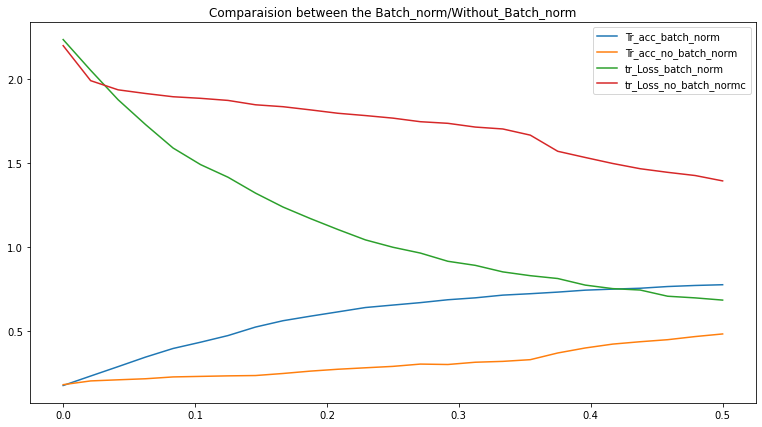

In [79]:
plt.figure(figsize=(13, 7))
x = np.linspace(0, .5, len(tl))


plt.plot(x, tba, label='Tr_acc_batch_norm')   
plt.plot(x, ta, label='Tr_acc_no_batch_norm')   
plt.plot(x, tbl, label='tr_Loss_batch_norm')  
plt.plot(x, tl, label='tr_Loss_no_batch_normc')  
plt.legend(fontsize=10)    
plt.title("Comparaision between the Batch_norm/Without_Batch_norm")   
plt.savefig(os.path.join(figures_path, 'Standard Training.png'), dpi=500, quality=100) 


C:\Users\compu\Anaconda3\envs\Bdeep\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


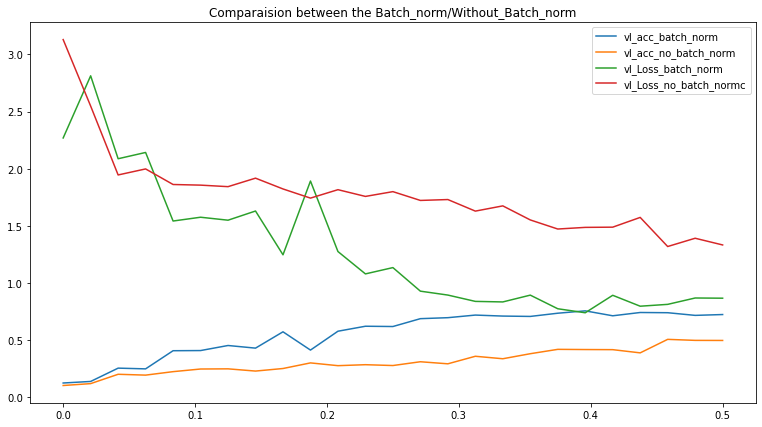

In [80]:
plt.figure(figsize=(13, 7))
x = np.linspace(0, .5, len(tl))
   
plt.plot(x, vba, label='vl_acc_batch_norm')   
plt.plot(x, va, label='vl_acc_no_batch_norm')   
plt.plot(x, vbl, label='vl_Loss_batch_norm')  
plt.plot(x, vl, label='vl_Loss_no_batch_normc')  
plt.legend(fontsize=10)    
plt.title("Comparaision between the Batch_norm/Without_Batch_norm")   
plt.savefig(os.path.join(figures_path, 'Standard validation.png'), dpi=500, quality=100)  